# Sign Language digit classification using RNN

Dataset: https://www.kaggle.com/ardamavi/sign-language-digits-dataset

Hint: Recurrent Neural Network for image classification

### Librairies 

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from os import listdir
from os.path import isfile, join
import imageio
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Step 1. Preprocess the data as per the given task

In [3]:
# The data are images with sign language of numbers from 0 to 9. 
# Each sign language number is in a specific folder

### Step 2. Write custom dataloader and collate function for creating train dataset and test dataset

In [4]:
# Path to the images
path_images = '/media/macaire/Ubuntu/Master_2/Neural_Networks/sign-language-digit-classification/Dataset/'


class SignDataset(Dataset):
    """SignDataset class to read the dataset
    Inherit from torch.utils.data.Dataset
    functions: init, len, getitem and find_files"""
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_files = self._find_files()
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        elements = list(self.image_files.items())
#         print(elements[index][0])
        image = io.imread(elements[index][0])
        label = torch.tensor(int(elements[index][1]))
        if self.transform:
            image = self.transform(image)
        return (image, label)
    
    
    def _find_files(self):
        """Recursively finds all files matching the pattern."""
        files = {}
        for i in range(0,10):
            images = [f for f in listdir(self.root_dir+'/'+str(i)) if isfile(join(self.root_dir+'/'+str(i), f))]
            for el in images:
                files[self.root_dir+str(i)+'/'+el] = i
        return files

    
class SignCollate(object):
    """Function object used as a collate function for DataLoader."""
    def __init__(self, ):
        pass
        
    def _collate_fn(self, batch):
        new_batch = []
        for idx in range(len(batch)):
            sample = batch[idx][0]
            label = batch[idx][1]
            new_batch.append(sample)

        # scalar output
        sample_batch = np.array(new_batch)
        sample_batch = torch.FloatTensor(sample_batch)
       
        return sample_batch

    def __call__(self, batch):
        return self._collate_fn(batch)

In [23]:
dataset = SignDataset(root_dir=path_images, transform=transforms.ToTensor())  # access to the dataset
print(len(dataset))  # 20 images

collate_fn = SignCollate()

batch_size = 1

# Split into TRAIN and TEST
train_size = int(0.9 * len(dataset))  # 90% of the data for train set
test_size = len(dataset) - train_size  # 10 % of the data for test set
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# for i, (x,y) in enumerate(train_dataset):
#     print(x)

2059


### Step 3. Define the neural network model in pytorch

In [24]:
# Neural Network model -> Recurrent Neural Network (RNN)
class RNN_LSTM_classifier(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(RNN_LSTM_classifier, self).__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        r_out, (_, _) = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out
    
#         super(RNN_LSTM_classifier, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.num_direction = num_direction
        
#         if self.num_direction == 1:
#             self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
#         else:
#             self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
#         self.fc = nn.Linear(hidden_size*self.num_direction, num_classes)
        
#     def forward(self, x):
#         # batch_size x seq_len x input_size
#         # Forward propagate LSTM
#         out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out

### Step 4. Define hyperparameters to create instance of neural network model as well as parameters required to train neural network

In [28]:
# Hyperparameters
num_layers = 2
sequence_length = 32
input_size = 100
hidden_size = 32
num_classes = 10   # 10 classes (digits from 0 to 9)
num_epochs = 50   # for the training
learning_rate = 0.01

### Step 5. Write training loop for training the model

In [29]:
model = RNN_LSTM_classifier(hidden_size, num_classes).to(device)

In [30]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
#         print(i, images.shape, labels.shape, labels)
        images = images.to(device)
        labels = labels.to(device)
        images = images.reshape(-1, 300, input_size).to(device)
#         labels = labels.to(device)
        #print(images.shape, labels.shape)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/50], Step [100/1853], Loss: 2.5327
Epoch [1/50], Step [200/1853], Loss: 2.2433
Epoch [1/50], Step [300/1853], Loss: 2.5102
Epoch [1/50], Step [400/1853], Loss: 2.3820
Epoch [1/50], Step [500/1853], Loss: 2.2792
Epoch [1/50], Step [600/1853], Loss: 2.3931
Epoch [1/50], Step [700/1853], Loss: 2.5067
Epoch [1/50], Step [800/1853], Loss: 2.2562
Epoch [1/50], Step [900/1853], Loss: 2.2279
Epoch [1/50], Step [1000/1853], Loss: 2.2968
Epoch [1/50], Step [1100/1853], Loss: 2.3562
Epoch [1/50], Step [1200/1853], Loss: 2.3194
Epoch [1/50], Step [1300/1853], Loss: 2.4562
Epoch [1/50], Step [1400/1853], Loss: 2.4003
Epoch [1/50], Step [1500/1853], Loss: 2.1873
Epoch [1/50], Step [1600/1853], Loss: 2.1308
Epoch [1/50], Step [1700/1853], Loss: 2.2780
Epoch [1/50], Step [1800/1853], Loss: 2.3870
Epoch [2/50], Step [100/1853], Loss: 2.4456
Epoch [2/50], Step [200/1853], Loss: 2.2972
Epoch [2/50], Step [300/1853], Loss: 2.1347
Epoch [2/50], Step [400/1853], Loss: 2.2776
Epoch [2/50], Step [500

Epoch [11/50], Step [500/1853], Loss: 2.3368
Epoch [11/50], Step [600/1853], Loss: 2.1156
Epoch [11/50], Step [700/1853], Loss: 2.2398
Epoch [11/50], Step [800/1853], Loss: 2.2302
Epoch [11/50], Step [900/1853], Loss: 2.2517
Epoch [11/50], Step [1000/1853], Loss: 2.3458
Epoch [11/50], Step [1100/1853], Loss: 2.1198
Epoch [11/50], Step [1200/1853], Loss: 2.8245
Epoch [11/50], Step [1300/1853], Loss: 2.2308
Epoch [11/50], Step [1400/1853], Loss: 2.2104
Epoch [11/50], Step [1500/1853], Loss: 3.2461
Epoch [11/50], Step [1600/1853], Loss: 2.3070
Epoch [11/50], Step [1700/1853], Loss: 2.1598
Epoch [11/50], Step [1800/1853], Loss: 2.1374
Epoch [12/50], Step [100/1853], Loss: 2.2651
Epoch [12/50], Step [200/1853], Loss: 2.2611
Epoch [12/50], Step [300/1853], Loss: 2.3267
Epoch [12/50], Step [400/1853], Loss: 2.5885
Epoch [12/50], Step [500/1853], Loss: 2.3074
Epoch [12/50], Step [600/1853], Loss: 1.1614
Epoch [12/50], Step [700/1853], Loss: 2.3971
Epoch [12/50], Step [800/1853], Loss: 0.3853
E

Epoch [21/50], Step [600/1853], Loss: 2.1455
Epoch [21/50], Step [700/1853], Loss: 2.5857
Epoch [21/50], Step [800/1853], Loss: 2.1349
Epoch [21/50], Step [900/1853], Loss: 2.4480
Epoch [21/50], Step [1000/1853], Loss: 2.1923
Epoch [21/50], Step [1100/1853], Loss: 2.4682
Epoch [21/50], Step [1200/1853], Loss: 0.8428
Epoch [21/50], Step [1300/1853], Loss: 2.3563
Epoch [21/50], Step [1400/1853], Loss: 2.1033
Epoch [21/50], Step [1500/1853], Loss: 2.4095
Epoch [21/50], Step [1600/1853], Loss: 2.3893
Epoch [21/50], Step [1700/1853], Loss: 2.0691
Epoch [21/50], Step [1800/1853], Loss: 2.6962
Epoch [22/50], Step [100/1853], Loss: 2.4729
Epoch [22/50], Step [200/1853], Loss: 2.4013
Epoch [22/50], Step [300/1853], Loss: 2.3892
Epoch [22/50], Step [400/1853], Loss: 2.2393
Epoch [22/50], Step [500/1853], Loss: 2.2402
Epoch [22/50], Step [600/1853], Loss: 2.2552
Epoch [22/50], Step [700/1853], Loss: 0.3653
Epoch [22/50], Step [800/1853], Loss: 2.2021
Epoch [22/50], Step [900/1853], Loss: 2.2418
E

Epoch [31/50], Step [700/1853], Loss: 1.8678
Epoch [31/50], Step [800/1853], Loss: 2.1304
Epoch [31/50], Step [900/1853], Loss: 2.0303
Epoch [31/50], Step [1000/1853], Loss: 2.2185
Epoch [31/50], Step [1100/1853], Loss: 1.9797
Epoch [31/50], Step [1200/1853], Loss: 1.9698
Epoch [31/50], Step [1300/1853], Loss: 2.1936
Epoch [31/50], Step [1400/1853], Loss: 2.1310
Epoch [31/50], Step [1500/1853], Loss: 3.1592
Epoch [31/50], Step [1600/1853], Loss: 2.5027
Epoch [31/50], Step [1700/1853], Loss: 2.0991
Epoch [31/50], Step [1800/1853], Loss: 2.1112
Epoch [32/50], Step [100/1853], Loss: 2.2218
Epoch [32/50], Step [200/1853], Loss: 2.3490
Epoch [32/50], Step [300/1853], Loss: 2.4271
Epoch [32/50], Step [400/1853], Loss: 2.4883
Epoch [32/50], Step [500/1853], Loss: 3.1199
Epoch [32/50], Step [600/1853], Loss: 2.0047
Epoch [32/50], Step [700/1853], Loss: 2.3172
Epoch [32/50], Step [800/1853], Loss: 2.1478
Epoch [32/50], Step [900/1853], Loss: 2.3060
Epoch [32/50], Step [1000/1853], Loss: 2.2146


Epoch [41/50], Step [800/1853], Loss: 1.8697
Epoch [41/50], Step [900/1853], Loss: 2.2772
Epoch [41/50], Step [1000/1853], Loss: 2.1170
Epoch [41/50], Step [1100/1853], Loss: 2.3450
Epoch [41/50], Step [1200/1853], Loss: 2.2007
Epoch [41/50], Step [1300/1853], Loss: 2.2303
Epoch [41/50], Step [1400/1853], Loss: 2.2975
Epoch [41/50], Step [1500/1853], Loss: 3.2351
Epoch [41/50], Step [1600/1853], Loss: 0.2533
Epoch [41/50], Step [1700/1853], Loss: 2.3657
Epoch [41/50], Step [1800/1853], Loss: 2.2393
Epoch [42/50], Step [100/1853], Loss: 2.2599
Epoch [42/50], Step [200/1853], Loss: 2.1001
Epoch [42/50], Step [300/1853], Loss: 2.3907
Epoch [42/50], Step [400/1853], Loss: 2.3803
Epoch [42/50], Step [500/1853], Loss: 2.4417
Epoch [42/50], Step [600/1853], Loss: 2.1693
Epoch [42/50], Step [700/1853], Loss: 2.3882
Epoch [42/50], Step [800/1853], Loss: 3.0457
Epoch [42/50], Step [900/1853], Loss: 2.3482
Epoch [42/50], Step [1000/1853], Loss: 2.2719
Epoch [42/50], Step [1100/1853], Loss: 2.1498

### Step 6. Evaluate the model on test data. In this part, it is expected to choose appropriate evaluation metrics based on your task. For an instance, for classification task, accuracy, precision and recall should be computed

In [11]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 300, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(round((100 * correct / total), 2))) 
    print('Precision: {} %'.format(round(torch.tensor(precision_score(labels,predicted, average='weighted')).item()*100, 2)))
    print('Recall: {} %'.format(round(torch.tensor(recall_score(labels,predicted, average='weighted')).item()*100, 2)))
    

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10000 test images: 34.95 %
Precision: 29.17 %
Recall: 28.57 %


/home/macaire/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/macaire/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Step 7. Save the obtained results

Predicted label:  7
Correct label:  4


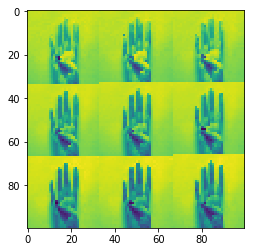

---------------------------
Predicted label:  7
Correct label:  6


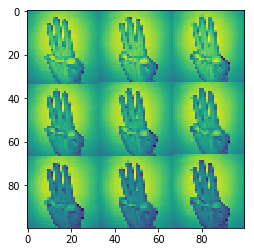

---------------------------
Predicted label:  1
Correct label:  0


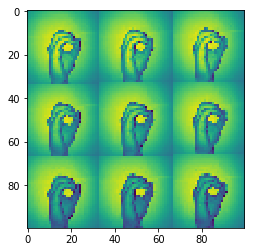

---------------------------
Predicted label:  0
Correct label:  3


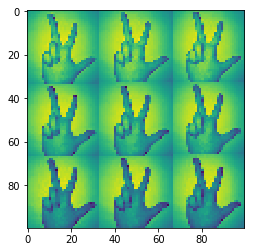

---------------------------
Predicted label:  7
Correct label:  0


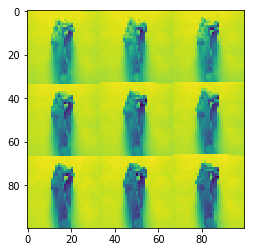

---------------------------
Predicted label:  7
Correct label:  1


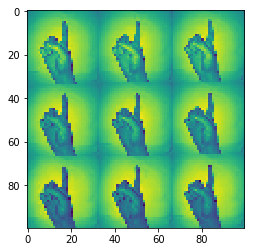

---------------------------
Predicted label:  0
Correct label:  7


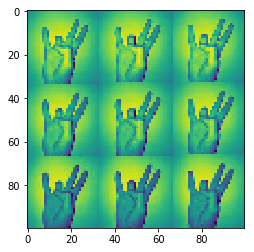

---------------------------
Predicted label:  7
Correct label:  8


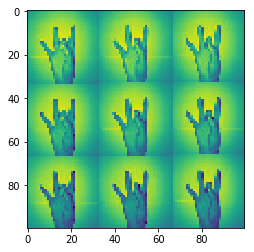

---------------------------
Predicted label:  0
Correct label:  3


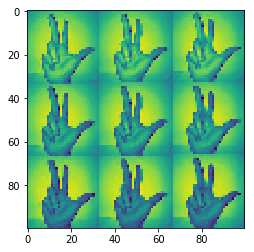

---------------------------
Predicted label:  1
Correct label:  3


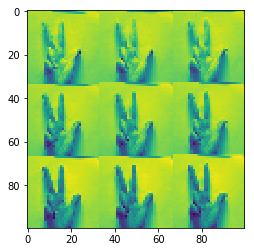

---------------------------
Predicted label:  7
Correct label:  6


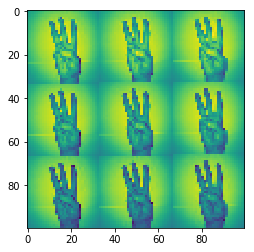

---------------------------
Predicted label:  7
Correct label:  3


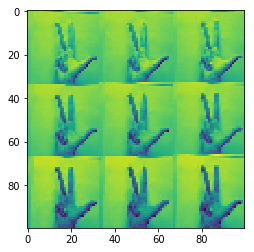

---------------------------
Predicted label:  0
Correct label:  0


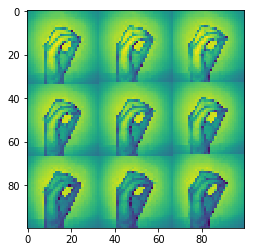

---------------------------
Predicted label:  7
Correct label:  2


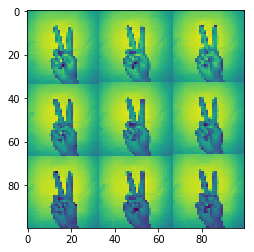

---------------------------
Predicted label:  7
Correct label:  5


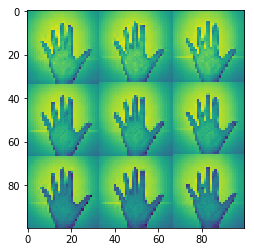

---------------------------
Predicted label:  7
Correct label:  6


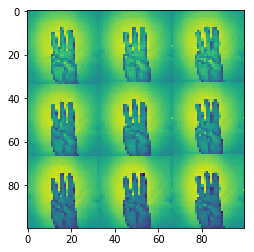

---------------------------
Predicted label:  7
Correct label:  4


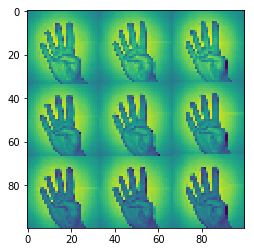

---------------------------
Predicted label:  7
Correct label:  8


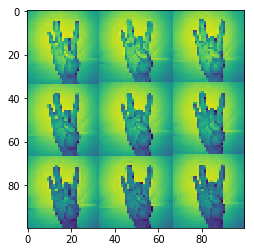

---------------------------
Predicted label:  7
Correct label:  8


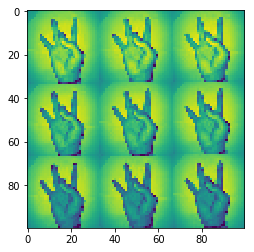

---------------------------
Predicted label:  7
Correct label:  2


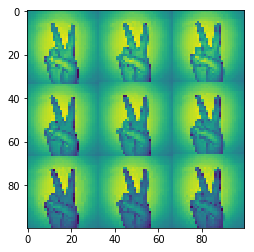

---------------------------
Predicted label:  7
Correct label:  9


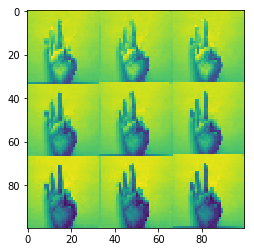

---------------------------
Predicted label:  7
Correct label:  3


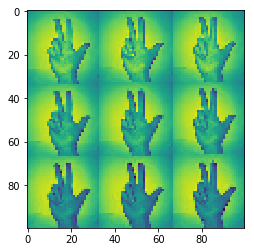

---------------------------
Predicted label:  7
Correct label:  7


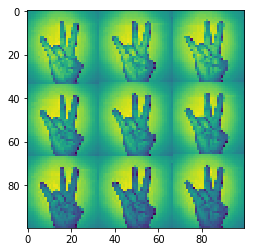

---------------------------
Predicted label:  7
Correct label:  7


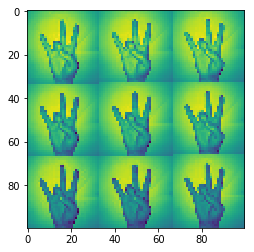

---------------------------
Predicted label:  0
Correct label:  4


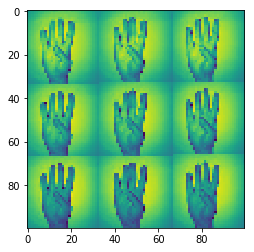

---------------------------
Predicted label:  7
Correct label:  2


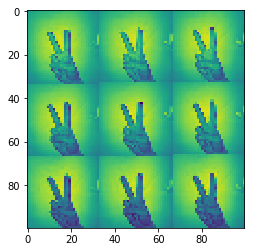

---------------------------
Predicted label:  7
Correct label:  0


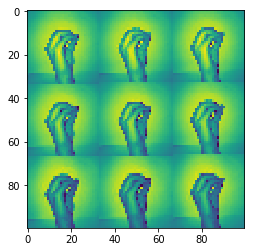

---------------------------
Predicted label:  1
Correct label:  0


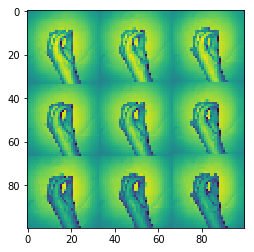

---------------------------
Predicted label:  7
Correct label:  9


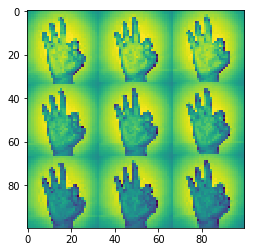

---------------------------
Predicted label:  7
Correct label:  6


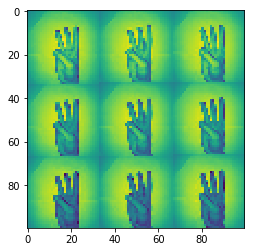

---------------------------
Predicted label:  7
Correct label:  4


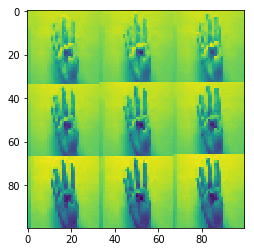

---------------------------
Predicted label:  7
Correct label:  8


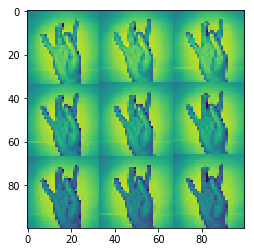

---------------------------
Predicted label:  1
Correct label:  2


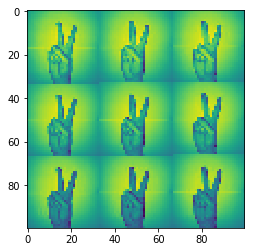

---------------------------
Predicted label:  7
Correct label:  4


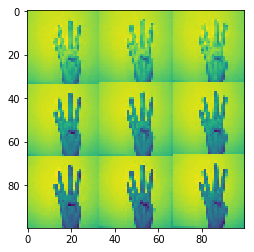

---------------------------
Predicted label:  0
Correct label:  0


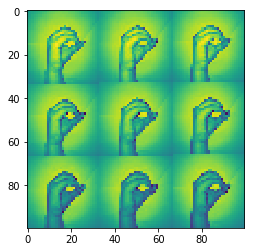

---------------------------
Predicted label:  7
Correct label:  2


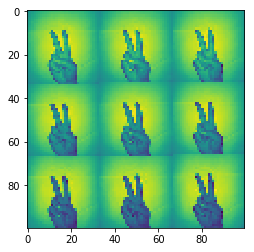

---------------------------
Predicted label:  7
Correct label:  1


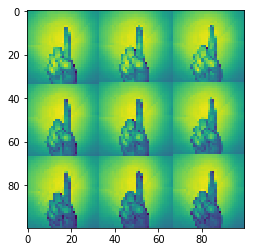

---------------------------
Predicted label:  7
Correct label:  4


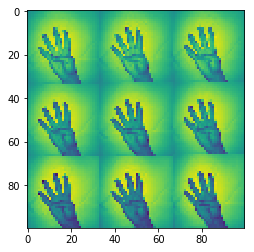

---------------------------
Predicted label:  7
Correct label:  8


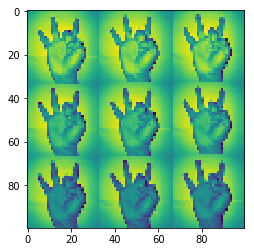

---------------------------
Predicted label:  7
Correct label:  8


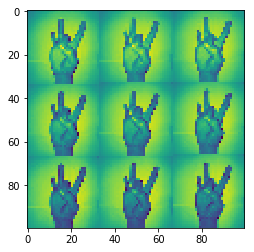

---------------------------
Predicted label:  7
Correct label:  8


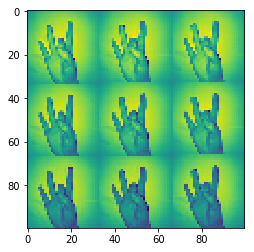

---------------------------
Predicted label:  7
Correct label:  8


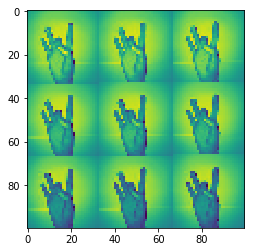

---------------------------
Predicted label:  7
Correct label:  7


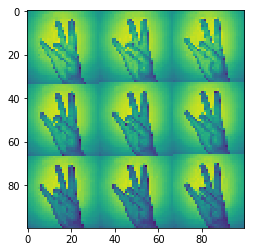

---------------------------
Predicted label:  7
Correct label:  5


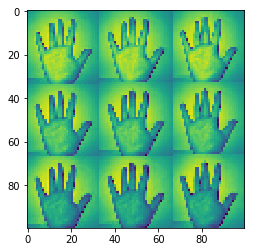

---------------------------
Predicted label:  7
Correct label:  8


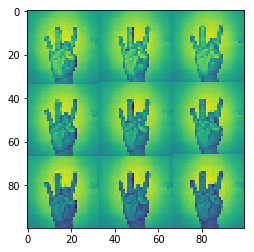

---------------------------
Predicted label:  0
Correct label:  5


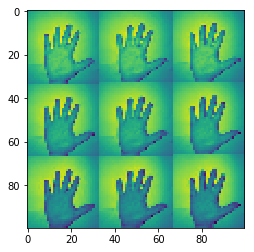

---------------------------
Predicted label:  7
Correct label:  1


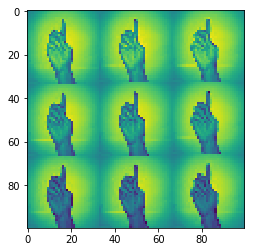

---------------------------
Predicted label:  7
Correct label:  5


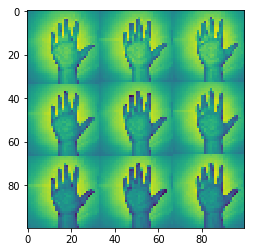

---------------------------
Predicted label:  7
Correct label:  7


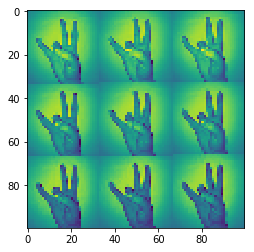

---------------------------
Predicted label:  7
Correct label:  8


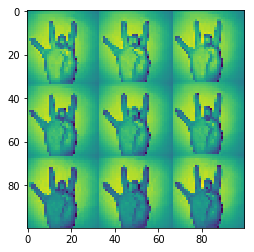

---------------------------
Predicted label:  7
Correct label:  6


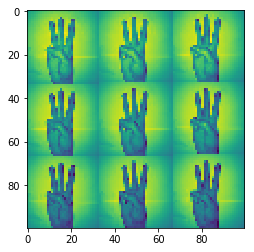

---------------------------
Predicted label:  7
Correct label:  7


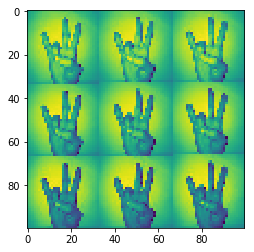

---------------------------
Predicted label:  7
Correct label:  5


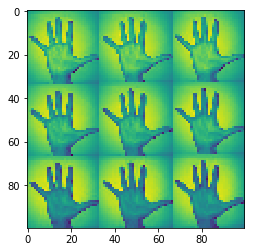

---------------------------
Predicted label:  7
Correct label:  9


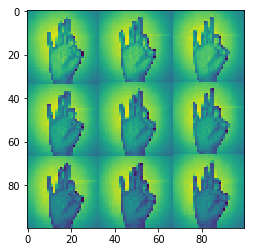

---------------------------
Predicted label:  7
Correct label:  6


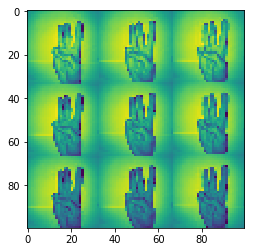

---------------------------
Predicted label:  1
Correct label:  1


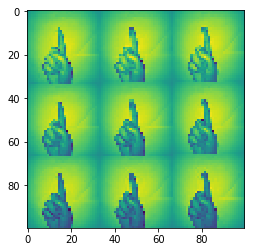

---------------------------
Predicted label:  7
Correct label:  4


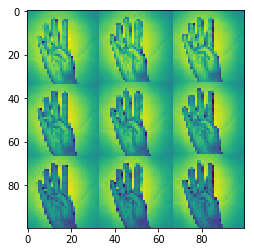

---------------------------
Predicted label:  7
Correct label:  3


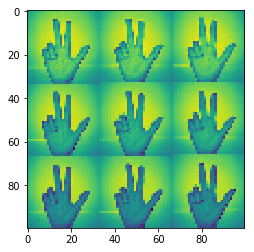

---------------------------
Predicted label:  7
Correct label:  2


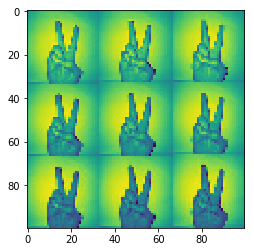

---------------------------
Predicted label:  7
Correct label:  9


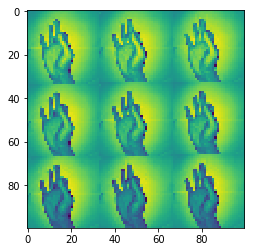

---------------------------
Predicted label:  7
Correct label:  0


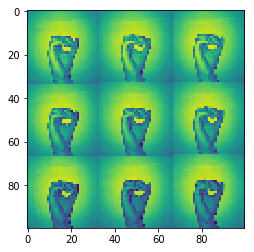

---------------------------
Predicted label:  7
Correct label:  5


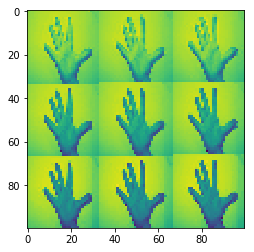

---------------------------
Predicted label:  1
Correct label:  3


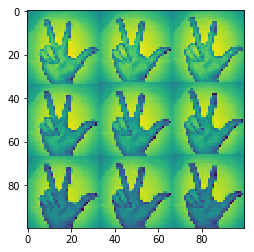

---------------------------
Predicted label:  7
Correct label:  1


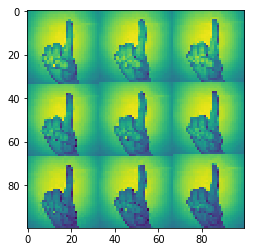

---------------------------
Predicted label:  7
Correct label:  7


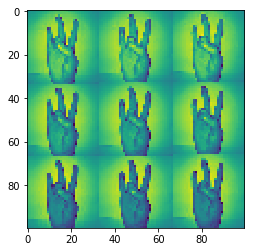

---------------------------
Predicted label:  7
Correct label:  4


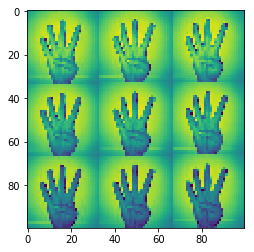

---------------------------
Predicted label:  7
Correct label:  7


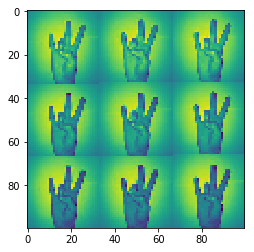

---------------------------
Predicted label:  7
Correct label:  9


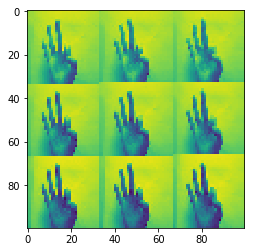

---------------------------
Predicted label:  7
Correct label:  8


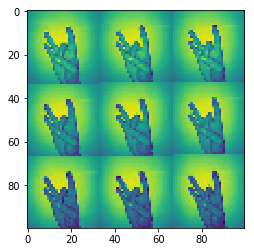

---------------------------
Predicted label:  7
Correct label:  8


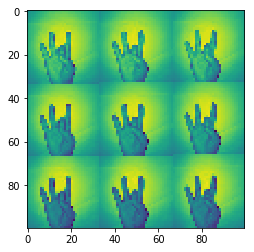

---------------------------
Predicted label:  7
Correct label:  6


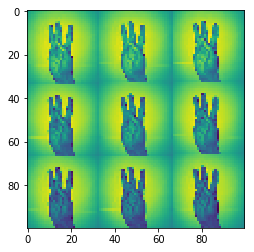

---------------------------
Predicted label:  7
Correct label:  5


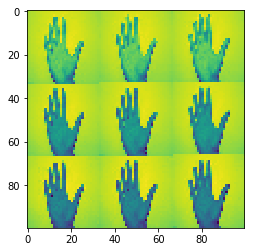

---------------------------


KeyboardInterrupt: 

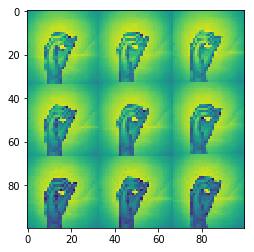

In [42]:
for i, (images, labels) in enumerate(test_loader):
#     print(images.shape)
#     print(images)
    show_image = images.reshape(-1, 100, 100, 3).to(device)
    x_np = show_image.numpy()
    plt.imshow(x_np[0][:,:,1])
    images = images.reshape(-1, 300, input_size).to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    print('Predicted label: ', int(predicted))
    print('Correct label: ', int(labels))
    plt.show()
#     print(images.shape)
    print('---------------------------')